In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_iris

iris_data = load_iris()
df = pd.DataFrame(np.c_[ iris_data['data'], iris_data['target'] ],
                    columns=iris_data['feature_names'] + ['target'])

In [3]:
def split_dataset(X, y, test_size, shuffle=True):
    n_samples = X.shape[0]
    permut = np.random.permutation(n_samples) if shuffle else range(n_samples)
    split_point = round((1-test_size)*n_samples)

    X_train, y_train = X[permut[:split_point]], y[permut[:split_point]]
    X_test, y_test = X[permut[split_point:]], y[permut[split_point:]]

    return X_train, X_test, y_train, y_test

In [4]:
def one_hot_encoder(target):
    keys = list(set(target))
    values = list(range(len(keys)))
    class_dict = {key:val for (key, val) in zip(keys, values)}

    target_one_hot = np.zeros((target.shape[0], len(keys)), dtype=int)
    for i, item in enumerate(target):
        target_one_hot[i, class_dict[item]] = 1

    return target_one_hot

In [179]:
X_iris = df.drop(columns=['target']).to_numpy()
y_iris = one_hot_encoder(df['target'].to_numpy())
X_train, X_test, y_train, y_test = split_dataset(X_iris, y_iris, test_size=0.2)

In [168]:
class three_layer_nn:
    def __init__(self, n_hidden):
        self.n_hidden = n_hidden

    def initial_weights(self, n_features, n_classes):
        self.w_1 = np.random.random(size=(self.n_hidden, n_features))
        self.b_1 = np.zeros(shape=self.n_hidden)
        self.w_2 = np.random.random(size=(n_classes, self.n_hidden))
        self.b_2 = np.zeros(shape=n_classes)

    def compute_cost(self, y):
        n_samples = y.shape[1]
        loss = -np.sum(y*np.log(self.y_hat), axis=0)
        cost = np.sum(loss) / n_samples

        return cost

    def relu(self, X):
        return np.maximum(X, 0.)

    def relu_grad(self, X):
        X[X<=0] = 0.
        X[X>0] = 1.
        
        return X

    def softmax(self, y_hat):
        y_hat = np.exp(y_hat)
        y_hat = y_hat / np.sum(y_hat, axis=0)

        return y_hat

    def forward_propagation(self, X):
        self.z_1 = self.w_1 @ X + self.b_1.reshape(-1, 1)
        self.a_1 = self.relu(self.z_1)
        self.z_2 = self.w_2 @ self.a_1 + self.b_2.reshape(-1, 1)
        self.y_hat = self.softmax(self.z_2)

    def backpropagation(self, X, y):
        n_samples = X.shape[1]

        self.dz_2 = self.y_hat - y
        self.dw_2 = (self.dz_2 @ self.a_1.T) / n_samples
        self.db_2 = np.sum(self.dz_2, axis=1) / n_samples
        
        self.dz_1 = (self.w_2.T @ self.dz_2) * self.relu_grad(self.z_1)
        self.dw_1 = (self.dz_1 @ X.T) / n_samples
        self.db_1 = np.sum(self.dz_1, axis=1) / n_samples

    def update_params(self, learning_rate):
        self.w_1 = self.w_1 - learning_rate*self.dw_1
        self.b_1 = self.b_1 - learning_rate*self.db_1

        self.w_2 = self.w_2 - learning_rate*self.dw_2
        self.b_2 = self.b_2 - learning_rate*self.db_2

    def train_GD(self, X, y, learning_rate, epochs, random_state=1):
        np.random.seed(random_state)
        n_features, n_classes = X.shape[0], y.shape[0]
        cost_history = np.zeros(shape=epochs)
        self.initial_weights(n_features, n_classes)

        for epoch in range(epochs):
            self.forward_propagation(X)
            self.backpropagation(X, y)
            self.update_params(learning_rate)

            cost_history[epoch] = self.compute_cost(y)

            if (epoch+1) % (epochs//10) == 0 or epoch == 0:
                print(f'iteration: {epoch+1:>5}/{epochs},\tcost: {cost_history[epoch]:>6.5f}')

        return cost_history

    def predict(self, X):
        n_classes, n_samples = self.y_hat.shape[0], X.shape[1]

        self.forward_propagation(X)
        pred = np.zeros(shape=(n_classes, n_samples))
        indices = np.argmax(self.y_hat, axis=0)
        for i in range(n_samples):
            pred[indices[i], i] = 1

        return pred

    def score(self, y_true, y_pred):
        n_correct, n_samples = 0, y_true.shape[1]
        for i in range(n_samples):
            if np.all(y_true[:, i] == y_pred[:, i]):
                n_correct += 1

        return n_correct/n_samples

    def plot_history(self, epochs, history, title, figsize=(10, 5)):
        plt.figure(figsize=figsize)
        plt.plot(list(range(epochs)), history)
        plt.xlabel('Iteration')
        plt.ylabel('Cost')
        plt.title(title)
        plt.show()

iteration:     1/5000,	cost: 3.57581
iteration:   500/5000,	cost: 0.38714
iteration:  1000/5000,	cost: 0.22868
iteration:  1500/5000,	cost: 0.15342
iteration:  2000/5000,	cost: 0.11859
iteration:  2500/5000,	cost: 0.10009
iteration:  3000/5000,	cost: 0.08888
iteration:  3500/5000,	cost: 0.08143
iteration:  4000/5000,	cost: 0.07613
iteration:  4500/5000,	cost: 0.07218
iteration:  5000/5000,	cost: 0.06912


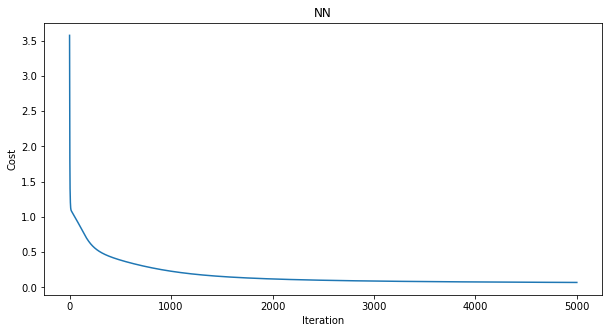

Train score: 0.9917, Test score: 0.9333


In [196]:
n_hidden = 4
epochs = 5000
lr = 0.01

model = three_layer_nn(n_hidden)
h = model.train_GD(X_train.T, y_train.T, lr, epochs)
model.plot_history(epochs, h, 'NN')

y_hat_train = model.predict(X_train.T)
score_train = model.score(y_train.T, y_hat_train)
y_hat_test = model.predict(X_test.T)
score_test = model.score(y_test.T, y_hat_test)
print(f'Train score: {score_train:.4}, Test score: {score_test:.4}')